In [1]:
# Gaussian process example.
#
# http://betatim.github.io/posts/gaussian-processes-with-george/

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import george
from george.kernels import ExpSquaredKernel, Matern32Kernel

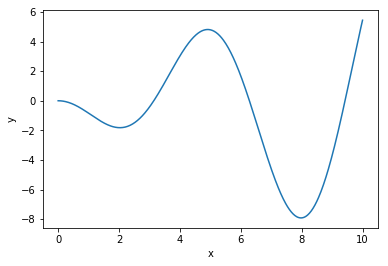

In [5]:
#
# Objective Function
#
# This is the function we are trying to model using gaussian process regression.
# Of course, in real-world, we don't know this function.
xsinx = lambda x: -x*np.sin(x)

# Plot and show the function.
t = np.linspace(0, 10, 500) # Return 500 evenly spaced numbers over range [0, 10]
plt.plot(t, xsinx(t))
plt.ylabel("y")
plt.xlabel("x")
plt.show()

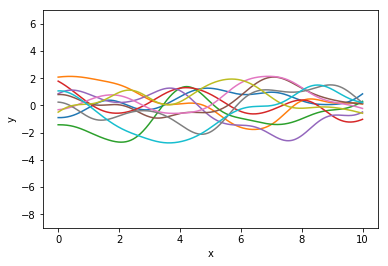

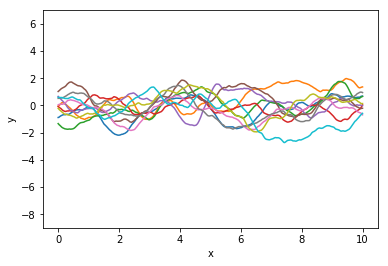

In [6]:
#
# Gaussian Process (with zero knowledge).
#
# Set up a gaussian process. The main ingredient of a gaussian process is the
# kernel. It describes how correlated each point is with every other.
kernel = ExpSquaredKernel(1.0)
gp = george.GP(kernel)

# Here we draw plot to show what kind of function we have when the gaussian
# process have no knowledge of our objective value of our function. We draw
# 10 samples below:
fig, ax = plt.subplots()
for pred in gp.sample(t, 10):
  ax.plot(t, pred)
ax.set_ylim(-9, 7)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# If we choose a different kernel, the functions we sample will end up looking
# different.
matern_kernel = Matern32Kernel(1.0)
matern_gp = george.GP(matern_kernel)
fig, ax = plt.subplots()
for pred in matern_gp.sample(t, 10):
  ax.plot(t, pred)
ax.set_ylim(-9, 7)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

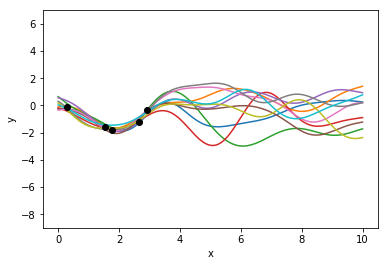

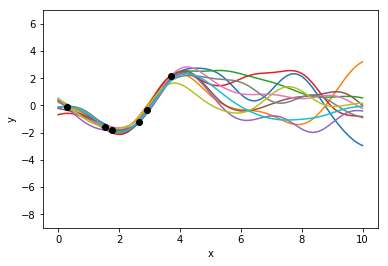

In [12]:
#
# Adding Knowledge
#
# Generate some fake, noisy data. In real world, this is the objective value
# from the function we are trying to model.
x = 10 * np.sort(np.random.rand(10))
yerr = 0.2 * np.ones_like(x)
y = xsinx(x) + yerr * np.random.randn(len(x))

# Here we provide 5 points for the gaussian process, then plot the lines to see
# what is the function estimations from it.
#
# Use gp.compute() to pre-compute the covariance matrix and factorize it for a
# set of times and uncertainties. Then use sample_conditional() to draw samples
# from the predictive conditional distribution. compute() must be called before
# sample_conditional().
Nmax = 5
fig, ax = plt.subplots()
gp.compute(x[:Nmax], yerr[:Nmax])
for pred in gp.sample_conditional(y[:Nmax], t, 10):
  ax.plot(t, pred)
ax.errorbar(x[:Nmax], y[:Nmax], yerr=yerr[:Nmax], fmt='ok', zorder=3)
ax.set_ylim(-9, 7)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Use 6 points, we'll see that the estimation is closer to the real function.
Nmax = 6
fig, ax = plt.subplots()
gp.compute(x[:Nmax], yerr[:Nmax])
for pred in gp.sample_conditional(y[:Nmax], t, 10):
  ax.plot(t, pred)
ax.errorbar(x[:Nmax], y[:Nmax], yerr=yerr[:Nmax], fmt='ok', zorder=3)
ax.set_ylim(-9, 7)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

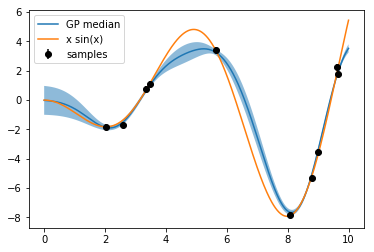

In [8]:
#
# All together.
#
# Below we use all samples from x to predict our model. A gaussian process
# provides you with its best guess and an uncertainty for every point of your
# function. As you add more data however you get a better and better estimate.
# All without having to make any assumptions about the shape of the function
# you are looking for.
#
# Use predict() to compute the conditional predictive distribution of the model.
# compute() must be called before predict().
gp.compute(x, yerr)
mu, cov = gp.predict(y, t)
std = np.sqrt(np.diag(cov))

fig, ax = plt.subplots()
ax.plot(t, mu, label="GP median")
ax.plot(t, xsinx(t), label="x sin(x)")
ax.fill_between(t, mu-std, mu+std, alpha=0.5)
# explicit zorder to draw points and errorbars on top of everything
ax.errorbar(x, y, yerr=yerr, fmt='ok', zorder=3, label="samples")
ax.legend(loc='best')
plt.show()

# Note that points chosen here are random: x = 10 * np.sort(np.random.rand(10))
# However, it is better if we can use algorithm to find the next best point
# based on existing points and objective value, to make estimation faster and
# more accurate. There is where bayesian optimisation comes into play.

In [20]:
help(gp.compute)
help(gp.sample_conditional)
help(gp.predict)

Help on method compute in module george.gp:

compute(x, yerr=0.0, **kwargs) method of george.gp.GP instance
    Pre-compute the covariance matrix and factorize it for a set of times
    and uncertainties.
    
    :param x: ``(nsamples,)`` or ``(nsamples, ndim)``
        The independent coordinates of the data points.
    
    :param yerr: (optional) ``(nsamples,)`` or scalar
        The Gaussian uncertainties on the data points at coordinates
        ``x``. These values will be added in quadrature to the diagonal of
        the covariance matrix.

Help on method sample_conditional in module george.gp:

sample_conditional(y, t, size=1) method of george.gp.GP instance
    Draw samples from the predictive conditional distribution. You must
    call :func:`GP.compute` before this function.
    
    :param y: ``(nsamples, )``
        The observations to condition the model on.
    
    :param t: ``(ntest, )`` or ``(ntest, ndim)``
        The coordinates where the predictive distribution sh